In [1]:
import numpy as np
from readers import HaloReader,SnapshotReader
from correlations import PowerSpectrum
from time import time
import gc

import matplotlib.pyplot as plt
import matplotlib.colors as pltcol

In [2]:
sim_stem = 'testTF128'
snap = 9
real = 1
grid = 128
downsample=0
Npmin = 30

Seed = 42
# start_time = time()
sr = SnapshotReader(sim_stem=sim_stem,real=real,snap=snap)
pos = sr.read_block('pos',down_to=downsample,seed=Seed)
# vel = sr.read_block('vel',down_to=downsample,seed=Seed)
# ids = sr.read_block('ids',down_to=downsample,seed=Seed)

Snapshot Reader:
... preparing to read file: testTF128/r1/snapshot_009.hdf5
... loaded header and parameters
... reading Coordinates


In [3]:
hr = HaloReader(sim_stem='testTF128',real=real,snap=snap)
QE = 0.5 # 0.5 recommended by Bett+07
massdef = 'm200b'
mmin = hr.mpart*Npmin
hpos,halos = hr.prep_halos(massdef=massdef,QE=QE,Npmin=Npmin)

Snapshot Reader:
... preparing to read file: testTF128/r1/snapshot_009.hdf5
... loaded header and parameters
... preparing halo data
... using file: testTF128/r1/out_9.trees
... ... using mass definition m200b > 1.520e+14 Msun/h
... ... only relaxed objects retained with 0.50 < 2T/|U| < 1.50
... ... discarding subhalos
... ... kept 1365 of 1825 objects in catalog
... ... sorting by m200b


In [ ]:
ps = PowerSpectrum(grid=256,Lbox=sr.Lbox)
delta_dm = ps.density_field(pos)
FT_delta_dm = ps.fourier_transform_density(delta_dm)
Pk_mm = ps.Pk_grid(FT_delta_dm,input_is_FTdensity=True)

delta_h = ps.density_field(hpos)
FT_delta_h = ps.fourier_transform_density(delta_h)
Pk_hh = ps.Pk_grid(FT_delta_h,input_is_FTdensity=True)
Pk_hm = ps.Pk_grid(FT_delta_h,input_array2=FT_delta_dm,input_is_FTdensity=True)

Pk_hh -= ps.Lbox**3/(halos.size + ps.TINY)
if downsample > 0:
    Pk_mm -= ps.Lbox**3/(downsample**3)
else:
    Pk_mm -= ps.Lbox**3/(sr.npart)

# del pos#,vel,ids
# del delta_dm, FT_delta_dm,delta_h,FT_delta_h
# gc.collect()

sr.print_this('... done',ps.logfile)

In [ ]:
# outfile_Pk = sr.sim_path + sim_stem + '/r'+str(real)+'/Pk_{0:03d}.txt'.format(snap)
# sr.print_this('Writing to file: '+outfile_Pk,sr.logfile)
# f = open(outfile_Pk,'w')
# f.write("# P(k) (DM,halos,cross) from snapshot_{0:03d}\n".format(snap))
# down = downsample if downsample > 0 else np.rint(sr.npart**(1/3.)).astype(int)
# f.write("# grid = {0:d}; downsampled to ({1:d})^3 particles\n".format(grid,down))
# f.write("# Halos satisfy {0:.2f} < 2T/|U| < {1:.2f}\n".format(1.-QE,1.+QE))
# f.write("# "+massdef+" > {0:.4e} Msun/h\n".format(hr.mpart*Npmin))
# f.write("# k (h/Mpc) | P(k) (Mpc/h)^3 | Phalo | Pcross\n")
# f.close()
# for k in range(ps.ktab.size):
#     sr.write_to_file(outfile_Pk,[ps.ktab[k],Pk_mm[k],Pk_hh[k],Pk_hm[k]])
# sr.print_this('... done',ps.logfile)

# # sr.time_this(start_time)

In [ ]:
plt.xscale('log');plt.yscale('log')
plt.plot(ps.ktab,Pk_mm,'k-',label='matter')
plt.plot(ps.ktab,Pk_hh,'r-',label='halos')
plt.plot(ps.ktab,Pk_hm,'b-',label='cross')
plt.show()

plt.xscale('log')
plt.plot(ps.ktab,Pk_hm/Pk_mm,'k-',label='$b_1(k)$')
plt.show()

In [15]:
tags = ['mvir','m200b','m200c'] 
ntags = len(tags)
mass_string = ''
for t in tags[:-1]: mass_string += t+','
mass_string += tags[-1]

lgmmin = np.log10(mmin)
lgmmax = 16.0
dlgm = 0.1
dlnm = dlgm*np.log(10)
nlgm = int((lgmmax-lgmmin)/dlgm)
mbins = np.logspace(lgmmin,lgmmax,nlgm+1)
mcenter = np.sqrt(mbins[1:]*mbins[:-1])

dndlnm = np.zeros((ntags,nlgm),dtype=float)
Vbox = sr.Lbox**3
for t in range(ntags):
    tag = tags[t]
    dndlnm[t],temp = np.histogram(halos[tag],bins=mbins,density=False)
    dndlnm[t] = dndlnm[t]/dlnm/Vbox
    if tag==massdef:
        sr.print_this("Nhalos: direct = {0:d}; integrated = {1:.1f}\n"
                      .format(halos.size,Vbox*dlnm*np.sum(dndlnm[t])),sr.logfile)

# outfile_mf = sr.halo_path + sim_stem + '/r'+str(real)+'/mf_{0:d}.txt'.format(snap)
# sr.print_this('Writing to file: '+outfile_mf,sr.logfile)
# fh = open(outfile_mf,'w')
# fh.write("#\n# Mass functions for " + sim_stem + '/'+'r'+str(real)+'/out_' + str(snap)+"\n")
# fh.write("# This file contains dn/dlnm (h/Mpc)^3 for various mass definitions.\n")
# fh.write("#\n# mass (Msun/h) | dndlnm["+mass_string+"]\n")
# fh.close()
# for m in range(nlgm):
#     mlist = [mcenter[m]]
#     for t in range(ntags):
#         mlist.append(dndlnm[t,m])
#     sr.write_to_file(outfile_mf,mlist)

Nhalos: direct = 1365; integrated = 1365.0

Writing to file: /home/aseem/iucaa/Sahyadri/sahyadri-sandbox/Test/halos/testTF128/r1/mf_9.txt


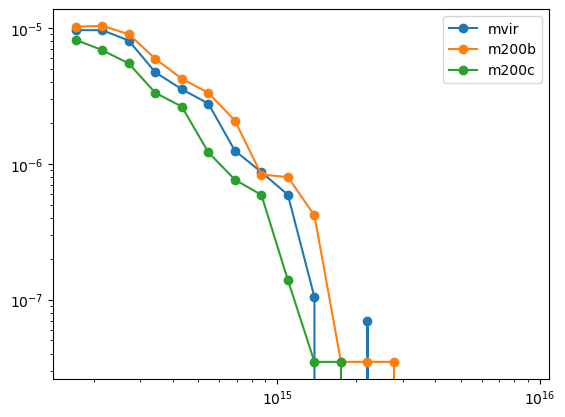

In [22]:
plt.yscale('log')
plt.xscale('log')
for t in range(ntags):
    plt.plot(mcenter,dndlnm[t],'-',marker='o',label=tags[t])#,drawstyle='steps-mid')
plt.legend()
plt.show()